# Limit Cycle Oscillation Analysis Notebook
A notebook for making plots to demonstrate the limit cycle oscillation (LCO) behavior of the fluctuations

## Setup

In [2]:
# %% Imports
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.interpolate

from adios2 import FileReader
from netCDF4 import Dataset

from tqdm.notebook import tqdm

from c1lgkt.fields.equilibrium import Equilibrium
from c1lgkt.fields.field_handlers import GaussHermiteFieldHandler, XgcZonalFieldHandler, XgcFieldHandler
from c1lgkt.fields.geometry_handlers import XgcGeomHandler

import c1lgkt.particles.particle_motion as particle_motion
import c1lgkt.particles.particle_tools as particle_tools

In [3]:
# %% Load data files
eq = Equilibrium.from_eqdfile(R'D:\Documents\IFS\hmode_jet\D3D141451.eqd')
xgcdata = Dataset(R'D:\Documents\Globus\XGC1.nc')

geom_files = {
    'ele_filename': R'D:\Documents\IFS\hmode_jet\Seo.eqd.ele',
    'fdmat_filename': R'D:\Documents\IFS\hmode_jet\fdmat.pkl',
    'min_e_filename': R'D:\Documents\IFS\hmode_jet\min_E_mat.pkl'
}
geom = XgcGeomHandler(eq, xgcdata, theta0_mode='max_drive', **geom_files)


## Compute zonal flows
zpot = xgcdata['pot00'][:,:]
zpot_psi = xgcdata['psi00'][:]
t = xgcdata['t'][:]

zfield = np.diff(zpot, axis=1) / np.diff(zpot_psi)[np.newaxis,:]

In [4]:
# Phase velocity data
ph_data = np.load('./outputs/phase_vel.npz')
u_lstsq = ph_data['u_lstsq']
phimax = ph_data['phimax']

# Load summary statistics
summary_data = np.load('./outputs/summary_data.npz')

In [5]:
# %% Load profile data

# File for one-dimensional profile data
oned_file = R"D:\Documents\Globus\XGC1_HD3D_elec_rgn1_run4\xgc.oneddiag.bp"

with FileReader(oned_file) as s:
    ## inspect variables
    #vars = s.available_variables()
    #for name, info in vars.items():
    #    print("variable_name: " + name, end=" ")
    #    for key, value in info.items():
    #        print("\t" + key + ": " + value, end=" ")
    #    print()
    #print()

    # Load electron and ion gyrocenter densities
    e_gc_den = s.read('e_gc_density_df_1d', step_selection=[0, 500]).reshape((500,-1))
    i_gc_den = s.read('i_gc_density_df_1d', step_selection=[0, 500]).reshape((500,-1))
    i_T_perp = s.read('i_perp_temperature_df_1d', step_selection=[0, 500]).reshape((500,-1))

    psi_mks = s.read('psi_mks')

## Analysis and Plots

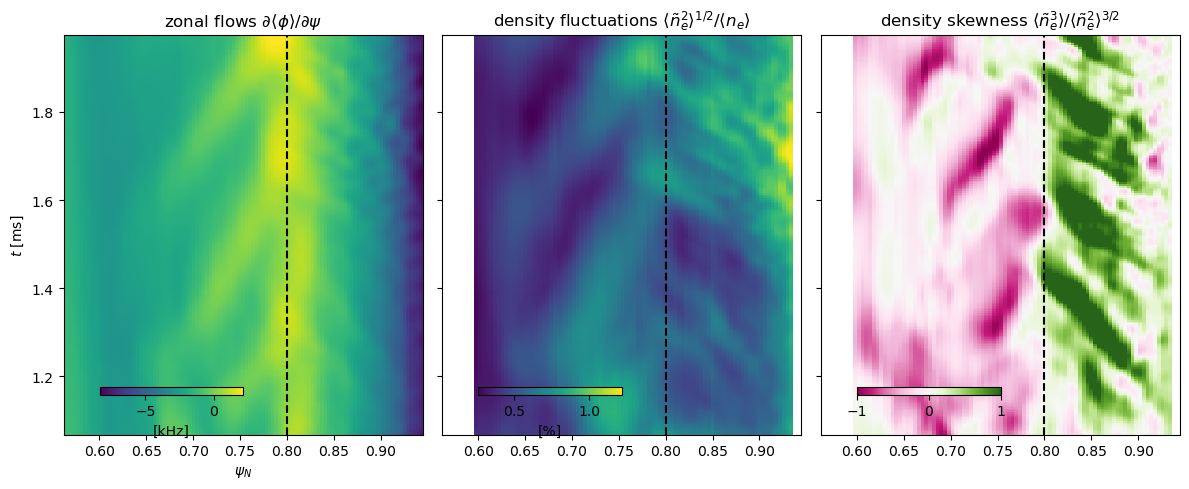

In [200]:
# %% Colormaps of the computed phase velocities and zonal flows

## Plot computed velocities
fig, axs = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(12,5))


tind0 = 270
surf0 = 150


pc = axs[0].pcolormesh(zpot_psi[160:-30]/eq.psix, t[tind0-1:]*1e3, -zfield[tind0:,160:-30]*1e-3)
axs[0].set_title(R'zonal flows $\partial \langle\phi\rangle / \partial \psi$')
cax = axs[0].inset_axes([0.1, 0.1, 0.4, 0.02])
plt.colorbar(pc, cax=cax, orientation='horizontal', label='[kHz]')


fluctuations = summary_data['e_den_var']/summary_data['e_den_avg']**2
pc = axs[1].pcolormesh(geom.psi_surf[surf0-1:-15]/eq.psix, t[tind0-1:]*1e3, np.sqrt(fluctuations)[tind0:,surf0:-15]*100)
axs[1].set_title(R'density fluctuations $\langle \tilde{n}_e^2 \rangle^{1/2} / \langle n_e \rangle$')
cax = axs[1].inset_axes([0.1, 0.1, 0.4, 0.02])
plt.colorbar(pc, cax=cax, orientation='horizontal', label='[%]')

skewness = summary_data['e_den_skw'] / summary_data['e_den_var']**1.5
pc = axs[2].pcolormesh(geom.psi_surf[surf0-1:-15]/eq.psix, t[tind0-1:]*1e3, skewness[tind0:,surf0:-15], vmin=-1, vmax=1, cmap='PiYG')
axs[2].set_title(R'density skewness $\langle \tilde{n}_e^3 \rangle / \langle \tilde{n}_e^2 \rangle^{3/2}$')
cax = axs[2].inset_axes([0.1, 0.1, 0.4, 0.02])
plt.colorbar(pc, cax=cax, orientation='horizontal')

axs[0].axvline(geom.psi_surf[200]/eq.psix, color='k', linestyle='--')
axs[1].axvline(geom.psi_surf[200]/eq.psix, color='k', linestyle='--')
axs[2].axvline(geom.psi_surf[200]/eq.psix, color='k', linestyle='--')


#axs[2].axvline(geom.psi_surf[190], color='k', linestyle='--')
#axs[2].axvline(geom.psi_surf[220], color='k', linestyle='--')

axs[0].set_xlabel(R'$\psi_N$')
axs[0].set_ylabel(R'$t$ [ms]')

plt.tight_layout()

C:\Users\maple\AppData\Local\Temp\ipykernel_21436\3253245946.py:12: RuntimeWarning: invalid value encountered in log
  e_gc_lne = -np.gradient(np.log(e_gc_den), axis=1) / np.gradient(psi_mks)


Text(0, 0.5, '$t$ [ms]')

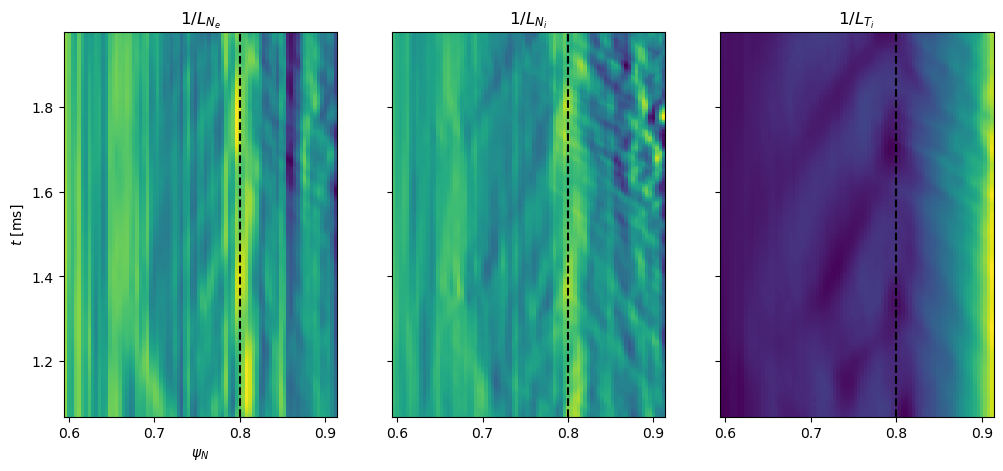

In [22]:
# %% Plot profiles in space-time

fig, axs = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(12,5))
tind0 = 270
surf0 = 150
surf1 = 230

# Set up colorbar
tw_repeated = mpl.cm.twilight(np.mod(np.linspace(0, 12, 256),1))
twr_cmap = mpl.colors.LinearSegmentedColormap.from_list('twilight_repeated', tw_repeated, N=256)

e_gc_lne = -np.gradient(np.log(e_gc_den), axis=1) / np.gradient(psi_mks)
i_gc_lne = -np.gradient(np.log(i_gc_den), axis=1) / np.gradient(psi_mks)
i_T_perp_lne = -np.gradient(np.log(i_T_perp), axis=1) / np.gradient(psi_mks)

axs[0].pcolormesh(psi_mks[surf0:surf1]/eq.psix, t[tind0:]*1e3, e_gc_lne[tind0:,surf0:surf1])
axs[0].set_title(R'$1/L_{N_e}$')

axs[1].pcolormesh(psi_mks[surf0:surf1]/eq.psix, t[tind0:]*1e3, i_gc_lne[tind0:,surf0:surf1])
axs[1].set_title(R'$1/L_{N_i}$')

axs[2].pcolormesh(psi_mks[surf0:surf1]/eq.psix, t[tind0:]*1e3, i_T_perp_lne[tind0:,surf0:surf1])
axs[2].set_title(R'$1/L_{T_i}$')


axs[0].axvline(geom.psi_surf[200]/eq.psix, color='k', linestyle='--')
axs[1].axvline(geom.psi_surf[200]/eq.psix, color='k', linestyle='--')
axs[2].axvline(geom.psi_surf[200]/eq.psix, color='k', linestyle='--')

axs[0].set_xlabel(R'$\psi_N$')
axs[0].set_ylabel(R'$t$ [ms]')

In [69]:
# %% Temporally averaged plots

plt.figure()
plt.plot(zpot_psi[131:-30], np.mean(zfield[tind0:,130:-30], axis=0))

plt.plot(geom.psi_surf[surf0:], np.mean(u_lstsq[tind0:,surf0:], axis=0))

plt.axvline(geom.psi_surf[220], color='k', linestyle='--')
#plt.plot(np.mean(zfield[tind0:,130:-30], axis=0))

[[ 1.         -0.23131884]
 [-0.23131884  1.        ]]


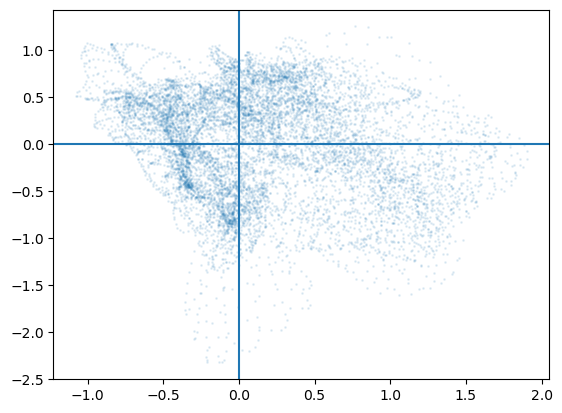

In [201]:
# %% Plot showing that temperature is anticorrelated with density in blobs
e_den_skwn = summary_data['e_den_skw'] / summary_data['e_den_var']**1.5
i_T_perp_skwn = summary_data['i_T_perp_skw'] / summary_data['i_T_perp_var']**1.5

plt.figure()
plt.scatter(e_den_skwn[250:,180:220].flatten(), i_T_perp_skwn[250:,180:220].flatten(), s=1, alpha=0.1)
plt.axvline()
plt.axhline()

print(np.corrcoef(e_den_skwn[250:,180:220].flatten(), i_T_perp_skwn[250:,180:220].flatten()))

In [119]:
# %% Corner plots

surfc = 196
surfcz = np.searchsorted(zpot_psi, geom.psi_surf[surfc])

data = [
    #(summary_data['e_den_skw'] / summary_data['e_den_var']**1.5)[tind0:,surfc],
    (summary_data['e_den_var'] * 1e-40)[tind0:,surfc],
    zfield[tind0:,surfcz],
    zfield[tind0:,surfcz-5],
]

fig, axs = plt.subplots(len(data)-1, len(data)-1, figsize=(8,8), sharex='col', sharey='row')
for i in range(len(data)-1):
    for j in range(len(data)):
        if i == j:
            #axs[i,j].hist(data[i], bins=30, color='C0', alpha=0.5)
            pass
        elif i < j:
            axs[i,j-1].scatter(data[j], data[i], c=t[tind0:])
            axs[i,j-1].plot(data[j], data[i], alpha=0.1, color='k')
            #axs[i,j].set_xlabel('x')
            #axs[i,j].set_ylabel('y')

plt.tight_layout(pad=0)

In [ ]:
# %% Temporal plots

plt.figure()

plt.plot(t[tind0:], data[1])
plt.twinx()
plt.plot(t[tind0:], data[2], c='tab:orange')


In [139]:
e_gc_den.shape

(132000,)

In [178]:
plt.figure()

plot_field = (np.gradient(np.log(i_gc_den), axis=1) + np.gradient(np.log(i_T_perp), axis=1))*i_T_perp
plot_field_avg = np.average(plot_field[:100], axis=0)
plt.plot(psi_mks[:240]/eq.psix, plot_field_avg[:240])
#plt.plot(psi_mks/eq.psix, e_gc_den.reshape((500, -1))[300,:])

In [181]:
# %% Pcolormesh of gradient
plt.figure()
plt.pcolormesh(psi_mks[120:230]/eq.psix, t[200:], -(np.gradient(i_gc_den, axis=1)/np.gradient(psi_mks)[np.newaxis,:])[200:,120:230])

In [140]:
geom.nsurf

250